In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
import datetime as d
import pytz
from itertools import groupby
import gsw

In [2]:
UTC = pytz.timezone('UTC')
ctdTimes = np.array(('Jun 24 2011 19:48:48', 'Jun 24 2011 23:33:12',\
           'Jun 25 2011 19:22:14', 'Jun 28 2011 16:54:47',\
           'Jul 03 2011 20:45:32', 'Jul 03 2011 21:37:50',\
           'Jul 04 2011 02:30:58', 'Jul 04 2011 03:05:38',\
           'Jul 06 2011 05:27:15', 'Jul 06 2011 06:30:11',\
           'Jul 06 2011 07:23:32', 'Jul 11 2011 06:42:49'))

ctdTimes = [UTC.localize(d.datetime.strptime\
            (t, '%b %d %Y %H:%M:%S')) for t in ctdTimes]
HST = pytz.timezone('US/Hawaii')

In [3]:
dataDirectory = '/Users/edwardlrichards/Documents/data/KAM11/enviornment/CTD/shipsCTD'
saveName = '/Users/edwardlrichards/cir_processing/Enviornment/processedData/psuProfiles.pic'
ctd_files = os.listdir(dataDirectory)
ctdData = None
lon = -159
lat = 22


# Filter used to detect upcast or downcast
N=512
Fc=0.001
Fs=1
h=sig.firwin(numtaps=N, cutoff=Fc, nyq=Fs/2)
castIndex = 0
for i, file in enumerate(ctd_files):
    
    fPath = os.path.join(dataDirectory, file)
    fileName, fileExtension = os.path.splitext(file)
    
    if fileExtension != '.cnv':
        continue
    with open(fPath) as f:
        for i, line in enumerate(f.readlines()):
            if line == '*END*\n':
                lineNumber = i
                break
                
    # CTD data from cast
    shipCTD = str(castIndex) + '_ctd'
    # T
    if file !='km1119_cast1SSPconv.cnv':
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', shipCTD,\
                'm', 'blah'], index_col='m')
    else:
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', shipCTD,\
                'avg m/s', 'm', 'blah'], index_col='m')
        del data['avg m/s']

    del data['S/m']
    del data['blah']
    
    # downcast detection, upcasts were not recorded
    eps = 0.0004
    y=sig.lfilter(h, 1.0, data.index)
    yDiff = np.diff(y)
    diffI = np.arange(yDiff.size)

    # Group casts by sign of depth derivative
    blocks = [list(g) for k, g in groupby(list(yDiff>eps))]
    
    blockI = 0
    longestBlock = 0
    currentI = 0
    for i, b in enumerate(blocks):
        if b[0] & (longestBlock < len(b)):
            longestBlock = len(b)
            blockI = i
            startIndex = currentI
        currentI += len(b)

#     plt.figure()
#     plt.plot(np.arange(data.index.size), data.index)
#     plt.plot(np.arange(data.index.size)[startIndex:(startIndex+longestBlock)],\
#              data.index[startIndex:(startIndex+longestBlock)],'r')
#     plt.title('ctd cast '+ fPath)

    data = data.iloc[startIndex:(startIndex+longestBlock), :]
    
    # interpolate data
    # Index to fractional meter spacing
    samplesPerMeter = 10
    newIndex = np.arange(np.ceil(np.max(np.array(data.index)))\
                         * samplesPerMeter) / samplesPerMeter
    
    data.sort_index()
    data = data.interpolate(method='nearest')
    _, index = np.unique(data.index, return_index=True)
    data = data.iloc[index]
    
    combinedIndex = data.index.append(pd.Index(newIndex))
    data = data.reindex(combinedIndex)
    # pressure in nan values should still change based on depth
    
    data.ix[pd.Index([0]), :] = data.iloc[0, :].values
    data.ix[pd.Index([0]), 'db'] = 0
    
    data[shipCTD] = data[shipCTD].interpolate(method='nearest')
    data['PSU'] = data['PSU'].interpolate(method='nearest')
    data['C'] = data['C'].interpolate(method='nearest')
    data['db'] = data['db'].interpolate(method = 'linear')
    
    # calculate sound speed from gsw
    abSal = gsw.SA_from_SP(data['PSU'], data['db'], lon, lat)
    conTemp = gsw.CT_from_t(abSal, data['C'], data['db'])
    gsw_SSP = gsw.sound_speed(abSal, conTemp, data['db'])
    
    del data['db']
    del data['C']
    del data[shipCTD]
    data[ctdTimes[castIndex]] = data['PSU']
    del data['PSU']

    data = data.ix[newIndex, :]

#     dataInterp = np.interp(oneMeter, data.index.values, data[castIndex].values)
#     data = pd.DataFrame(dataInterp, index = oneMeter, columns=[castIndex])
    
    if ctdData is None:
        ctdData = data
    else:
        ctdData = pd.merge(ctdData, data, left_index=True,
                            right_index=True, how='outer')
    castIndex += 1

In [4]:
ctdData.columns

<class 'pandas.tseries.index.DatetimeIndex'>
[2011-06-24 19:48:48+00:00, ..., 2011-07-11 06:42:49+00:00]
Length: 12, Freq: None, Timezone: UTC

In [5]:
interpPoints = np.array((0,70,120))
interpValues = np.array((35.05, 35.3, 35.3))
interpLine = np.interp(ctdData.index, interpPoints, interpValues)

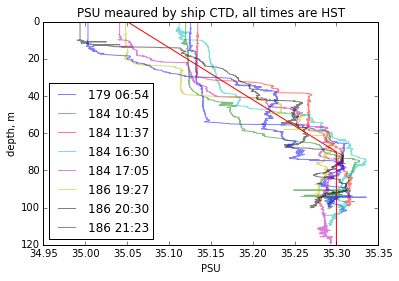

In [18]:
# Well fit ctds

# label datestring format
# dsFormat = '%m/%d %H:%M'
dsFormat = '%j %H:%M'

for i in ctdData.columns:
    if ctdData.ix[0, i] >= 34.95:
        # set up datetime label
        loc_dt = i.astimezone(HST)
        plt.plot(ctdData[i], ctdData.index, alpha=0.5,\
                label = loc_dt.strftime(dsFormat))
        
# _ = plt.plot(ctdData, ctdData.index, 'b', alpha=0.7)
_ = plt.plot(interpLine, ctdData.index, 'r')
_ = plt.ylim(120, 0)

_ = plt.legend(loc=3)
_ = plt.title('PSU meaured by ship CTD, all times are HST')
_ = plt.ylabel('depth, m')
_ = plt.xlabel('PSU')

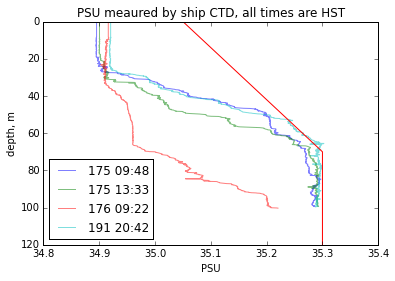

In [19]:
# Outliers
for i in ctdData.columns:
    if ctdData.ix[0, i] < 34.95:
        # set up datetime label
        loc_dt = i.astimezone(HST)
        plt.plot(ctdData[i], ctdData.index, alpha=0.5,\
                label = loc_dt.strftime(dsFormat))
        
_ = plt.plot(interpLine, ctdData.index, 'r')
_ = plt.ylim(120, 0)
_ = plt.legend(loc=3)
_ = plt.title('PSU meaured by ship CTD, all times are HST')
_ = plt.ylabel('depth, m')
_ = plt.xlabel('PSU')

In [9]:
ctdData.to_pickle(saveName)